<a href="https://colab.research.google.com/github/Developer-Gilbert/Practice-project/blob/main/Object_Detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection (객체 탐지)
- 컴퓨터 비전과 이미지 처리와 관련된 컴퓨터 기술로써, 디지털 이미지와 비디오로 특정한 계열의 시맨틱 객체 인스턴스를 감지하는 일
- 얼굴 검출, 보행자 검출 등이 포함

### 컴퓨터 비전의 Task 비교
- Image Classification : 이미지에 있는 개체 범주 목록 생성
- Single-Object Localization : 이미지에 있는 개체 범주의 한 인스턴스의 위치와 배율을 나타내는 bounding box 생성
- Objcet Detection : 각 개체 범주의 모든 인스턴스의 위치와 배율을 나타내는 bounding box와 함께 이미지에 있는 개체 목록 생성
- https://oniss.tistory.com/39

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import make_grid
from util import CLASS_NAME_TO_ID, visualize, save_model

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from collections import defaultdict

from torchvision.ops import nms

In [ ]:
data_df = pd.read_csv('./DataSet/df.csv')
data_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


In [ ]:
index = 49
image_files = [fn for fn in os.listdir('./DataSet/train/') if fn.endswith('jpg')]
image_file = image_files[index]
image_file

'00322d6b899f0fed.jpg'

In [ ]:
image_path = os.path.join('./DataSet/train/', image_file)
image_path

'./DataSet/train/00322d6b899f0fed.jpg'

In [ ]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(168, 256, 3)

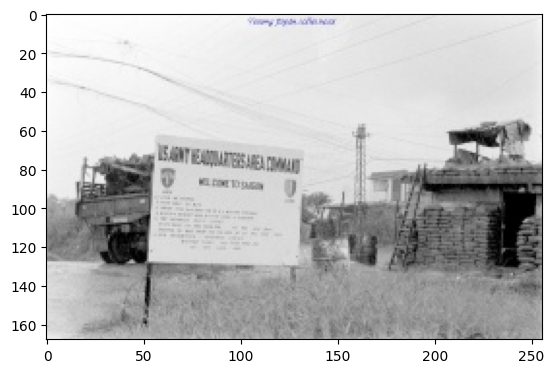

In [ ]:
plt.imshow(image)

In [ ]:
image_id = image_file.split('.')[0]
image_id

'00322d6b899f0fed'

In [ ]:
test_data = data_df[data_df['ImageID'] == image_id]
test_data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
79,00322d6b899f0fed,xclick,Truck,1,0.057617,0.211914,0.436012,0.767857,1,0,...,0,0,0.079102,0.057617,0.211914,0.131836,0.436012,0.578869,0.558036,0.767857


In [ ]:
label_name = test_data['LabelName'].values
label_name

array(['Truck'], dtype=object)

In [ ]:
bbox = test_data[['XMin', 'XMax', 'YMin', 'YMax']].values
bbox

array([[0.057617, 0.211914, 0.436012, 0.767857]])

In [ ]:
# 영상의 높이와 너비
img_H, img_W, _ = image.shape
img_H, img_W

# pycharm 을 열어서, 모듈을 만들거에요!

(168, 256)

In [ ]:
class_id = [CLASS_NAME_TO_ID[label] for label in label_name]
class_id

[1]

In [ ]:
unnorm_bboxes = bbox.copy()
unnorm_bboxes
# Xmin, XMax, YMin, YMax

array([[0.057617, 0.211914, 0.436012, 0.767857]])

In [ ]:
# Xmin, XMax, YMin, YMax -> XMin, YMin, XMax, YMax
unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]

In [ ]:
# XMin, YMin, XMax, YMax
# XMax - XMin, YMax - YMin
# XMin, YMin, W, H
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]

In [ ]:
# Xmin + (W/2), YMin + (H/2)
# XCen, YCen, W, H
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
unnorm_bboxes

array([[0.1347655, 0.6019345, 0.154297 , 0.331845 ]])

In [ ]:
unnorm_bboxes[:, [0, 2]] *= img_W
unnorm_bboxes[:, [1, 3]] *= img_H
unnorm_bboxes

array([[ 34.499968, 101.124996,  39.500032,  55.74996 ]])

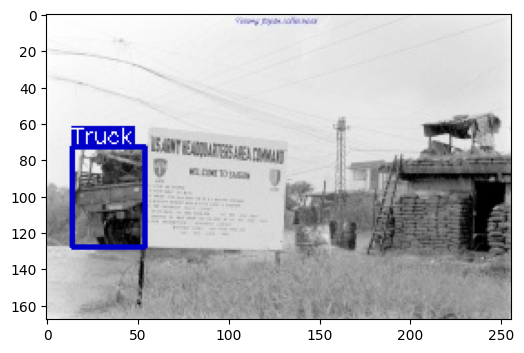

In [ ]:
canvas = visualize(image, unnorm_bboxes, class_id)
plt.figure(figsize = (6,6))
plt.imshow(canvas)
plt.show()

In [ ]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('./DataSet/train/', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    label_name = meta_data['LabelName'].values
    bbox = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
    img_H, img_W, _ = image.shape
    class_ids = [CLASS_NAME_TO_ID[label] for label in label_name]

    unnorm_bboxes = bbox.copy()
    unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
    unnorm_bboxes[:, [0, 2]] *= img_W
    unnorm_bboxes[:, [1, 3]] *= img_H

    canvas = visualize(image, unnorm_bboxes, class_ids)
    plt.figure(figsize = (6,6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [ ]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir,phase)) if fn.endswith('jpg')]
        self.transformer = transformer

    def __len__(self):
        return len(self.image_files)

    # 리턴을 무엇을 받을지는 여러분들이 결정.
    def __getitem__(self, index):
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)

        img_H, img_W, _ = image.shape
        if self.transformer:
            image = self.transformer(image)
            _, img_H, img_W = image.shape

        bboxes[:, [0, 2]] *= img_W
        bboxes[:, [1, 3]] *= img_H

        target = {}
        target['boxes'] = torch.Tensor(bboxes).float()
        target['labels'] = torch.Tensor(class_ids).long()

        return image, target, filename

    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image

    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = data_df[data_df['ImageID'] == image_id]
        label_name = meta_data['LabelName'].values
        class_ids = [CLASS_NAME_TO_ID[label] for label in label_name]

        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]]

        return bboxes, class_ids


In [ ]:
data_dir = './DataSet/'
dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=None)

In [ ]:
len(dataset)

13703

In [ ]:
dataset[27]

(array([[[255, 254, 255],
         [253, 251, 252],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[253, 251, 252],
         [255, 254, 255],
         [253, 253, 253],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 253],
         [253, 253, 251],
         [255, 255, 253],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[ 62,  65,  70],
         [ 66,  69,  74],
         [ 67,  70,  75],
         ...,
         [150, 149, 155],
         [150, 149, 155],
         [150, 149, 155]],
 
        [[ 65,  68,  73],
         [ 67,  70,  75],
         [ 67,  70,  75],
         ...,
         [155, 154, 160],
         [150, 149, 155],
         [148, 147, 153]],
 
        [[ 71,  75,  78],
         [ 71,  75,  78],
         [ 70,  73,  78],
         ...,
         [150, 151, 156],
  

In [ ]:
# 정리해서, 한 번 더 테스트
index = 22
image, target, filename = dataset[index]

[[  8.        18.88458  103.04      64.815796]
 [ 84.96      22.40535  235.04     157.3181  ]]
[[ 55.52      41.85019   95.04      45.931213]
 [160.        89.861725 150.07999  134.91275 ]]


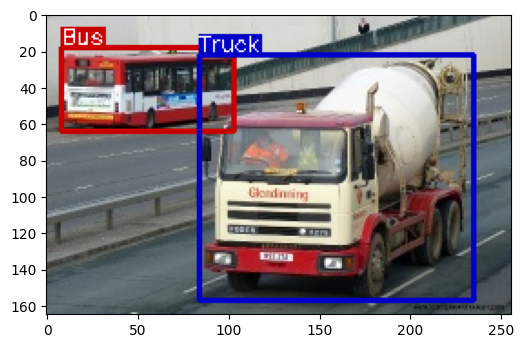

In [ ]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()
n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)

# XCen, YCen, W, H
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

print(boxes)
print(bboxes)

canvas = visualize(image, bboxes, class_ids)
plt.figure(figsize = (6,6))
plt.imshow(canvas)
plt.show()

In [ ]:
# 실습
# 인터렉트 그려보기 실습!
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):

    image, target, _ = dataset[index]
    boxes = target['boxes'].numpy()
    class_ids = target['labels'].numpy()

    n_obj = boxes.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)

    # XCen, YCen, W, H
    bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
    bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

    canvas = visualize(image, bboxes, class_ids)
    plt.figure(figsize = (6,6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [ ]:
# 트랜스포머 적용!
# R-CNN 이미지 사이즈가 448 고정!
IMAGE_SIZE = 448

# [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# ImageNet 얻어낸 평균과 표준편차
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
data_dir = './DataSet/'
transformed_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)

In [ ]:
index = 49
image, target, filename = transformed_dataset[index]
image.shape

torch.Size([3, 448, 448])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


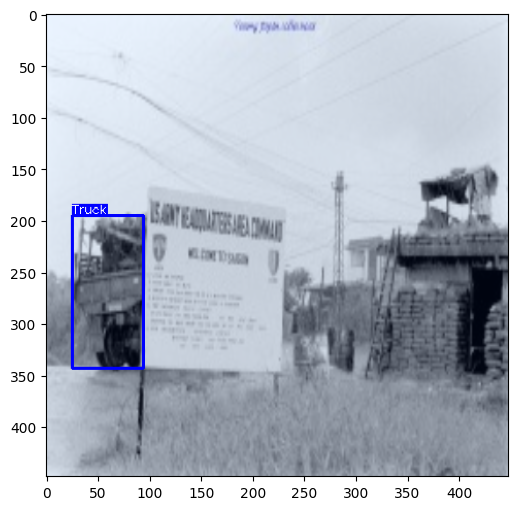

In [ ]:
np_image = make_grid(image, normalize=True).cpu().permute(1, 2, 0).numpy()
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()

n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)

# XCen, YCen, W, H
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(np_image, bboxes, class_ids)
plt.figure(figsize = (6,6))
plt.imshow(canvas)
plt.show()

In [ ]:
# 데이터 로더를 만들어보자!
# 변수 = DataLoader(데이터셋, batch_size=4, shuffle=True, collate_fn=함수명)

# collate_fn
# 배치사이즈만큼 나누어진 다음에 데이터를 가져와 처리하는 함수(처리할게 있을 경우)

def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for img, target, filename in batch:
        image_list.append(img)
        target_list.append(target)
        filename_list.append(filename)

    return image_list, target_list, filename_list

In [ ]:
# 데이터셋을 받아와, 로더를 만들자.
trainset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)

trainloarder = DataLoader(trainset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
for index, batch in enumerate(trainloarder):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    if index == 0:
        break

print(targets, filenames)

[{'boxes': tensor([[203.8400, 269.0540, 308.8400, 339.2785]]), 'labels': tensor([0])}, {'boxes': tensor([[  0.0000, 368.8420,  75.6000, 429.8945]]), 'labels': tensor([0])}, {'boxes': tensor([[ 12.5189, 190.0801, 167.6644, 314.2402],
        [131.8961, 208.6399, 401.9483, 431.3599]]), 'labels': tensor([0, 0])}, {'boxes': tensor([[ 74.7600, 165.7600, 378.2800, 312.8532]]), 'labels': tensor([1])}, {'boxes': tensor([[ 29.9600,  20.3365, 425.6000, 425.2712]]), 'labels': tensor([0])}, {'boxes': tensor([[ 29.4000,  60.6668, 446.6000, 364.9332]]), 'labels': tensor([1])}, {'boxes': tensor([[  0.0000,  32.8532, 447.7200, 447.6268]]), 'labels': tensor([0])}, {'boxes': tensor([[ 84.8400, 110.9494, 386.6800, 389.1633],
        [179.7600, 185.3358, 310.8000, 229.8836],
        [311.0800, 185.7560, 395.3600, 303.0093],
        [388.0800, 196.2625, 435.6800, 305.5311],
        [415.8000, 191.6396, 447.7200, 324.4429]]), 'labels': tensor([0, 0, 0, 0, 0])}] ['032925607ae0382c.jpg', '15fd4b729a6fb344.jpg

In [ ]:
# train 만 가지고 test 를 햇는데,
# train 과 val 둘 다 싸악 묶어서 처리.
def build_dataloader(data_dir, batch_size=4, image_size=448):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(image_size, image_size)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = Detection_dataset(data_dir=data_dir, phase='val', transformer=transformer)
    dataloaders['val'] = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [ ]:
# 데이터로더 동작 테스트
data_dir = './DataSet/'
dataloaders = build_dataloader(data_dir)

for phase in ['train', 'val']:
    for index, batch in enumerate(dataloaders[phase]):
        print('================================================')
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(targets)
        if index == 0:
            break

[{'boxes': tensor([[ 16.0998,   0.0000, 422.8000, 208.6000]]), 'labels': tensor([1])}, {'boxes': tensor([[101.0800,  86.4949, 428.9600, 392.5546],
        [403.7600,  86.0514, 447.7200, 210.6931]]), 'labels': tensor([1, 1])}, {'boxes': tensor([[ 94.9200, 206.8501, 434.8400, 367.4998]]), 'labels': tensor([1])}, {'boxes': tensor([[ 98.0000,  73.5894, 367.3600, 389.8245]]), 'labels': tensor([0])}]
[{'boxes': tensor([[154.0000,  69.9606, 407.1200, 291.2211]]), 'labels': tensor([0])}]


# Two_stage 모델
- 탐색 영역을 찾는 Region Proposal과 해당 영역을 분류하는 Detection 두 가지 과정이 순차적으로 수행되는 방법
- 위치를 찾는 문제(Localization)
    - 하나의 이미지 안에서 물체가 있을법한 위치를 찾아 나열하는 과정에 대한 정보를 제안
- 분류 문제(Classification)
    - 각각의 위치에 대한 class를 분류
    - 이미지 내의 사물에 존재하는 bounding box를 예측하는 regression 사용

### R-CNN
- Selective Search를 이용해 2,000개의 ROI를 추출
- 각 ROI에 대하여 동일한 크기의 입력 이미지로 변경
- 이미지를 CNN에 넣어서 벡터 이미지를 추출 (특징 추출)
- 해당 특징을 SVM에 넣어 class 분류 결과를 얻음

> 입력 이미지에 대해 CPU 기반의 Selective Search를 진행하므로 많은 시간이 소요

### Fast R-CNN
- 동일한 Region proposal을 이용하지만 이미지를 한 번만 CNN에 넣어 Feature Map을 생성

> 입력 이미지에 대해 CPU 기반의 Selective Search를 진행하므로 많은 시간이 소요

### Faster R-CNN
- 병목에 해당하던 Region proposal 작업을 GPU에서 수행함
- RPN(Region Proposal Networks) 적용
    - 슬라이딩 윈도우를 거쳐 각 위치에 대해 Regression과 Classification을 수행

# One_stage 모델
- Region Proposal과 Detection이 한 번에 수행
- YOLO(You only Look Once) : 2015년 제안된 객체 검출 모델로 이미지 전체를 단일 그리드로 나누고, 각 그리드 셀마다 여러 개의 바운딩 박스와 클래스를 예측하는 방식

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def build_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # import
    return model

In [ ]:
NUM_CLASSES = 2
model = build_model(num_classes=NUM_CLASSES)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
phase = 'train'
model.train()

for index, batch in enumerate(dataloaders[phase]):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    images = list(image for image in images)

    targets = [{k : v for k, v in t.items()} for t in targets]

    loss = model(images, targets)
    if index == 0:
        break

In [ ]:
# 클래스를 구분하는 스테이지
# loss_classifier : 버스냐 트럭이냐
# loss_box_reg : 바운딩 박스 값

# 오브젝트의 존재 여부 스테이지
# loss_objectness : 오브젝트가 있는지 없는지
# loss_rpn_box_reg : 박스에 대한 값

loss

{'loss_classifier': tensor(0.4526, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0200, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.1343, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0144, grad_fn=<DivBackward0>)}

In [ ]:
def train_one_epoch(dataloaders, model, optimizer, device):
    train_loss = defaultdict(float) # import 해줘야한다.
    val_loss = defaultdict(float)
    model.train()

    for phase in ['train', 'val']:
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0]
            targets = batch[1]
            filenames = batch[2]

        images = list(image for image in images)
        targets = [{k : v for k, v in t.items()} for t in targets]

        with torch.set_grad_enabled(phase == 'train'):
            loss = model(images, targets)

        total_loss =  sum(each_loss for each_loss in loss.values())

        if phase == 'train':
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if (index > 0) and (index % 100 == 0):
                text = f'{index}/{len(dataloaders[phase])} - '
                for k, v in loss.items():
                    text += f'{k} : {v.item():.4f} '
                print(text)

            for k, v in loss.items():
                train_loss[k] += v.item()
            train_loss['total_loss'] += total_loss.item()

        else:
            for k, v in loss.items():
                val_loss[k] += v.item()
            val_loss['total_loss'] += total_loss.item()

    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])

    return train_loss, val_loss

In [ ]:
# 정리 한 번,
data_dir = './DataSet/'
is_cuda = False
NUM_CLASSES = 2

device = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir)
model = build_model(num_classes=NUM_CLASSES)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# num_epochs = 30
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     train_loss, val_loss = train_one_epoch(dataloaders, model, optimizer, device)
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     print(f"epoch:{epoch+1}/{num_epochs} - Train Loss:{train_loss['total_loss']:.4f}, Val Loss:{val_loss['total_loss']:.4f}")

#     if (epoch+1) % 10 == 0:
#          save_model(model.state_dict(), f'model_{epoch+1}.pth')

In [ ]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = build_model(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [ ]:
model = load_model(ckpt_path='./trained_model/model_30.pth', num_classes=NUM_CLASSES, device=device)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Confidence Threshold
- 객체 탐지와 같은 작업에서 사용되는 개념
- 객체 탐지 모델은 입력 이미지에서 객체의 위치를 찾아내는 작업을 수행 -> 모델은 주어진 이미지 내에서 다양한 위치에 대해 객체가 존재하는지 예측하고 객체에 대한 바운딩 박스와 해당 객체에 대한 신뢰도(confidence score)를 출력
- Confidence Threshold : 신뢰도를 조절하는 기준 값
    - Confidence Threshold를 0.8로 설정하면 모델은 신뢰도가 0.8이상인 객체만을 선택하게 됨
- Confidence Threshold를 적절하게 설정해야 객체 탐지의 정확도를 높일 수 있음
    - 너무 낮은 Confidence Threshold를 설정하면 신뢰성이 낮은 결과를 포함할 수 있고, 너무 높은 Confidence Threshold를 설정하면 신뢰성이 높은 객체조차 누락

<img src='https://blog.kakaocdn.net/dn/96Xcc/btrAaVSmJqg/K69oluJU7oCqNHntQ8wh20/img.png' width='300'>

### Non-Maximum Suppression(NMS)
- 중복된 결과를 제거하여 정확하고 겹치지 않는 객체를 식별하는 데 사용
- NMS가 작동하는 순서
    - 객체 탐지 모델 실행(이미지를 입력받아 바운딩 박스와 신뢰도를 출력)
    - 바운딩 박스 필터링(겹치는 바운딩 박스들 중에서 가장 확실한 바운딩 박스만 남기고 나머지 겹치는 바운딩 박스를 제거 -> IoU 지표를 사용)

### IoU (Intersection over Union)
- 객체 탐지나 세그멘테이션과 같은 컴퓨터 비전에서 모델이 예측한 결과와 실제 라벨 사이의 정확도를 측정하는 지표
- 바운딩 박스나 세그멘테이션 마스크가 얼마나 겹치는지를 측정하여, 예측 결과의 정확성을 평가하는데 사용
- 0과 1 사이의 값으로 1에 가까울수록 예측 결과가 정확하고 겹치는 영역이 많다는 것을 의미
- 계산 방법
    - 영역 A와 영역 B의 겹치는 영역 계산 -> 공통 부분을 계산
    - 교집합 계산(얼마나 겹쳐져 있는지)
    - 합집합 계산(두 영역의 전체 크기)
    - IoU계산(교집합을 합집합으로 나눔 -> 교집합/합집합)

In [ ]:
# 후처리 하는 함수를 만들어서 처리해보자.

def postprocess(prediction, conf_thres=0.5, IoU_threshold=0.5):
    pred_box = prediction['boxes'].cpu().detach().numpy()
    pred_label = prediction['labels'].cpu().detach().numpy()
    pred_conf = prediction['scores'].cpu().detach().numpy()
    # 이 3개는 원래 키 값으로 저장되어있던 친구.

    valid_index = pred_conf > conf_thres
#    print('valid_index : ', valid_index)
    pred_box = pred_box[valid_index]
    pred_label = pred_label[valid_index]
    pred_conf = pred_conf[valid_index]

    # nms
    # from torchvision.ops import nms # import 함
    # 예측값, 신뢰도 값과 IoU 지표를 가지고 nms 를 구한다.
    valid_index = nms(torch.tensor(pred_box.astype(np.float32)), torch.tensor(pred_conf), IoU_threshold)
    pred_box = pred_box[valid_index.numpy()]
    pred_label = pred_label[valid_index.numpy()]
    pred_conf = pred_conf[valid_index.numpy()]
    return np.concatenate((pred_box, pred_conf[:, np.newaxis], pred_label[:, np.newaxis]), axis=1)

In [ ]:
pred_images = []
pred_labels = []

for index, (images, _, filenames) in enumerate(dataloaders['val']):
    images = list(image.to(device) for image in images)
    filename = filenames[0]

    image = make_grid(images[0].cpu().detach(), normalize=True).permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)

    with torch.no_grad():
        prediction = model(images)

    # 아까 만든 후처리함수에 넣어서 우리가 원하는 바를 리턴 받는다.
    # nms 계산한게 합쳐져서 리턴 될 것이다.
    prediction = postprocess(prediction[0])

    # 분해하는 작업
    prediction[:, 2].clip(min=0, max=image.shape[1])
    prediction[:, 3].clip(min=0, max=image.shape[0])

    xc = (prediction[:, 0] + prediction[:, 2]) / 2
    yc = (prediction[:, 1] + prediction[:, 3]) / 2
    w = prediction[:, 2] - prediction[:, 0]
    h = prediction[:, 3] - prediction[:, 1]
    cls_id = prediction[:, 5]

    prediction_yolo = np.stack([xc, yc, w, h, cls_id], axis = 1)

    pred_images.append(image)
    pred_labels.append(prediction_yolo)

    if index == 2:
        break

valid_index :  []
valid_index :  [ True  True False]
valid_index :  [False]


In [ ]:
pred_labels

[array([], shape=(0, 5), dtype=float64),
 array([[216.04582977, 130.02792931, 188.56770325, 132.44685745,
           1.        ],
        [381.14401245, 138.94155121, 131.83856201,  90.55845642,
           1.        ]]),
 array([], shape=(0, 5), dtype=float64)]

In [ ]:
@interact(index=(0, len(pred_images)-1))
def show_result(index=0):
    result = visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 4])
    plt.figure(figsize = (4, 4))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [ ]:
video_path = './sample_video.mp4'

In [ ]:
@torch.no_grad()
def model_predict(image, model):
    tensor_image = transformer(image)
    tensor_image = tensor_image.to(device)
    prediction = model([tensor_image])
    return prediction

In [ ]:
video = cv2.VideoCapture(video_path)

In [ ]:
while(video.isOpened()):
    ret, frame = video.read()
    if ret :
        ori_h, ori_w = frame.shape[:2]
        image = cv2.resize(frame, dsize=(448, 448))
        prediction = model_predict(image, model)
        prediction = postprocess(prediction[0])

        prediction[:, [0, 2]] *= (ori_w / 448)
        prediction[:, [1, 3]] *= (ori_h / 448)
        prediction[:, 2].clip(min=0, max=image.shape[1])
        prediction[:, 3].clip(min=0, max=image.shape[0])

        xc = (prediction[:, 0] + prediction[:, 2]) / 2
        yc = (prediction[:, 1] + prediction[:, 3]) / 2
        w = prediction[:, 2] - prediction[:, 0]
        h = prediction[:, 3] - prediction[:, 1]
        cls_id = prediction[:, 5]

        prediction_yolo = np.stack([xc, yc, w, h, cls_id], axis = 1)

        canvas = visualize(frame, prediction_yolo[:, 0:4], prediction_yolo[:, 4])
        cv2.imshow('canvas', canvas)

        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()

video.release()

valid_index :  [ True  True False]
valid_index :  [ True  True False]
valid_index :  [ True  True]
valid_index :  [ True  True False]
valid_index :  [ True  True  True]
valid_index :  [ True  True]
valid_index :  [ True  True]
valid_index :  [ True  True]
valid_index :  [ True  True]
valid_index :  [ True  True  True]
valid_index :  [ True  True False]
valid_index :  [ True  True]
valid_index :  [ True  True False]
valid_index :  [ True  True False]
valid_index :  [ True  True  True False]
valid_index :  [ True  True  True  True False]
valid_index :  [ True  True  True False False]
valid_index :  [ True  True  True False]
valid_index :  [ True  True  True False]
valid_index :  [ True  True False False]
valid_index :  [ True  True  True False]
valid_index :  [ True False False False]
valid_index :  [ True  True  True]
valid_index :  [ True  True  True]
valid_index :  [ True  True]
valid_index :  [ True  True]
valid_index :  [ True False]
valid_index :  [ True False]
valid_index :  [ Tru